In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, fbeta_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin



RANDOM_STATE = 42
TEST_SIZE=0.2

In [2]:
def preprocess_data(df):
    """
    Функция для базовой предобработки данных
    
    Параметры:
    df (pandas.DataFrame): Входной датафрейм
    
    Возвращает:
    pandas.DataFrame: Предобработанный датафрейм
    """
    # Создаем копию датафрейма
    df_processed = df.copy()
    
    # 1. Заменим названия столбцов на snake_case
    for col in df_processed.columns:
        df_processed.rename(columns={col: col.strip().replace(' ',"_")}, inplace=True)
    
    # 2. Обработка пропущенных значений
    # Удаление строк, где все значения отсутствуют
    #df_processed.dropna(how='all', inplace=True)
    
    # 3. Приведение названий колонок к нижнему регистру
    df_processed.columns = df_processed.columns.str.lower()
    
    # 4. Изучаем количественные переменные
    numeric_columns = df_processed.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        count_NA_num = df_processed[col].isna().sum()
        print(f"Количество пропусков в колонке {col}: {count_NA_num} \n")
        
    # 5. Изучаем категориальные значения
    categorical_columns = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        count_NA_cat = df_processed[col].isna().sum()
        print(f"Количество пропусков в колонке {col}: {count_NA_cat}")
        print(f"Уникальные значения {col}: {df_processed[col].unique()} \n")
    
    # 6. Удаление дубликатов
    df_processed.drop_duplicates(inplace=True)
    
    
    # 7. Удаление пробелов в строковых значениях
    for col in categorical_columns:
        df_processed[col] = df_processed[col].str.strip()
    
    return df_processed

In [3]:
#load datasets
df = pd.read_csv('heart_train.csv', index_col=0)
df_test = pd.read_csv('heart_test.csv')

In [4]:
df = preprocess_data(df)
#удаляем пропуски
df.dropna(inplace=True)

Количество пропусков в колонке age: 0 

Количество пропусков в колонке cholesterol: 0 

Количество пропусков в колонке heart_rate: 0 

Количество пропусков в колонке diabetes: 243 

Количество пропусков в колонке family_history: 243 

Количество пропусков в колонке smoking: 243 

Количество пропусков в колонке obesity: 243 

Количество пропусков в колонке alcohol_consumption: 243 

Количество пропусков в колонке exercise_hours_per_week: 0 

Количество пропусков в колонке diet: 0 

Количество пропусков в колонке previous_heart_problems: 243 

Количество пропусков в колонке medication_use: 243 

Количество пропусков в колонке stress_level: 243 

Количество пропусков в колонке sedentary_hours_per_day: 0 

Количество пропусков в колонке income: 0 

Количество пропусков в колонке bmi: 0 

Количество пропусков в колонке triglycerides: 0 

Количество пропусков в колонке physical_activity_days_per_week: 243 

Количество пропусков в колонке sleep_hours_per_day: 0 

Количество пропусков в колонк

In [5]:
for col in df.columns:
    if df[col].dtype == 'float64' and df[col].nunique() == 2:
        df[col] = df[col].astype('int64')

In [6]:
df['phys']=MinMaxScaler().fit_transform(df[['physical_activity_days_per_week']])
#df['diet_min']=MinMaxScaler().fit_transform(df[['diet']])
#df['stress']=MinMaxScaler().fit_transform(df[['stress_level']])
df.drop(columns=['physical_activity_days_per_week'])

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id,phys
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,...,0.333333,0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664,0.428571
1,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,...,0.833333,0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287,0.428571
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,...,1.000000,0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379,0.285714
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,...,0.333333,1,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222,0.000000
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,...,1.000000,1,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8680,0.359551,0.357143,0.040330,1,0,1,1,1,0.926662,2,...,0.166667,0,0.136364,0.006771,0.088261,Male,0.632258,0.511628,5734,0.000000
8681,0.516854,0.832143,0.036664,1,1,1,1,1,0.455572,2,...,0.833333,0,0.195652,0.008339,0.000777,Male,0.561290,0.511628,5191,0.857143
8682,0.471910,0.067857,0.023831,1,0,1,0,1,0.076336,2,...,0.833333,0,0.227018,0.048229,0.036512,Male,0.374194,0.558140,5390,0.142857
8683,0.595506,0.000000,0.075160,0,1,1,0,1,0.371759,2,...,0.500000,0,0.227018,0.048229,0.036512,Male,0.477419,0.744186,860,0.571429


In [7]:
df = df.loc[df['troponin'] < 0.08]
df = df.loc[df['ck-mb'] < 0.1]
df = df.loc[df['blood_sugar'] < 0.4]


<Axes: ylabel='Frequency'>

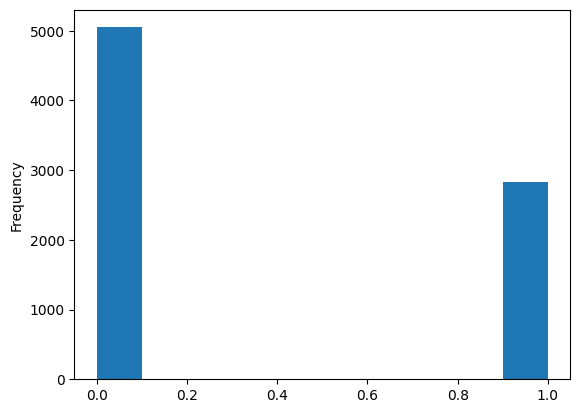

In [8]:
df['heart_attack_risk_(binary)'].plot(kind='hist')

In [9]:
df=df[[
 'bmi',
  'sedentary_hours_per_day',
  'triglycerides',
  'systolic_blood_pressure',
  'heart_rate', 'family_history', 'gender',
  'cholesterol', 'phys',
  'income', 'alcohol_consumption',
  'age', 'stress_level', 
  'diastolic_blood_pressure', 'heart_attack_risk_(binary)']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
      df.drop(columns=['heart_attack_risk_(binary)'], axis=1),
      df['heart_attack_risk_(binary)'],
      test_size = TEST_SIZE, 
      random_state = RANDOM_STATE)

In [11]:

# Подсчёт веса для каждого класса
class_counts = np.bincount(y_train)
total = sum(class_counts)
class_weights = [total / c for c in class_counts]

# Пример: если классов два
print("Веса классов:", class_weights)

Веса классов: [np.float64(1.5483554246440845), np.float64(2.8236347358997316)]


In [12]:
#model = CatBoostClassifier(l2_leaf_reg=1, learning_rate=1, iterations=500, depth=16, border_count=32, cat_features=['gender'], class_weights=class_weights, loss_function='Logloss', eval_metric='Recall')
model = CatBoostClassifier(l2_leaf_reg=1, learning_rate=1, iterations=1000, depth=16, early_stopping_rounds=50, border_count=32, cat_features=['gender'], class_weights=class_weights, loss_function='Logloss', eval_metric='Recall')
#model = CatBoostClassifier(l2_leaf_reg=1, learning_rate=1, iterations=1000, depth=16, early_stopping_rounds=50, border_count=32, cat_features=[], class_weights=class_weights, loss_function='Logloss', eval_metric='Recall')
model.fit(X_train, y_train)

0:	learn: 0.8742167	total: 113ms	remaining: 1m 52s
1:	learn: 0.9941808	total: 147ms	remaining: 1m 13s
2:	learn: 0.9995524	total: 182ms	remaining: 1m
3:	learn: 1.0000000	total: 218ms	remaining: 54.3s
4:	learn: 1.0000000	total: 259ms	remaining: 51.6s
5:	learn: 1.0000000	total: 295ms	remaining: 48.8s
6:	learn: 1.0000000	total: 340ms	remaining: 48.3s
7:	learn: 1.0000000	total: 372ms	remaining: 46.2s
8:	learn: 1.0000000	total: 403ms	remaining: 44.4s
9:	learn: 1.0000000	total: 438ms	remaining: 43.4s
10:	learn: 1.0000000	total: 482ms	remaining: 43.3s
11:	learn: 1.0000000	total: 521ms	remaining: 42.9s
12:	learn: 1.0000000	total: 560ms	remaining: 42.5s
13:	learn: 1.0000000	total: 594ms	remaining: 41.8s
14:	learn: 1.0000000	total: 628ms	remaining: 41.3s
15:	learn: 1.0000000	total: 659ms	remaining: 40.5s
16:	learn: 1.0000000	total: 691ms	remaining: 39.9s
17:	learn: 1.0000000	total: 722ms	remaining: 39.4s
18:	learn: 1.0000000	total: 753ms	remaining: 38.9s
19:	learn: 1.0000000	total: 783ms	remainin

In [13]:
threshold = 0.2

y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)

recall_score(y_test, y_pred), fbeta_score(y_test, y_pred, beta=1), roc_auc_score(y_test, y_pred)


(0.6312292358803987, 0.4960835509138381, np.float64(0.5338523228582321))

In [14]:
features = model.get_feature_importance(prettified=True)
features

,Feature Id,Importances
0,sedentary_hours_per_day,9.862552
1,age,9.296633
2,stress_level,8.706413
3,income,8.091702
4,systolic_blood_pressure,7.838722
5,bmi,7.788209
6,cholesterol,7.720343
7,diastolic_blood_pressure,7.423365
8,phys,7.242546
9,triglycerides,6.880504


In [15]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.plots.bar(shap_values)

/Users/mikhailpuchkov/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

: 

In [138]:
model.save_model("heart.cbm")

In [140]:
test = [12, 12, 12, 12, 12, 12, 'Male', 12,12,12,12,12,12,12]
y = model.predict_proba(test)
y

array([0.40244681, 0.59755319])

In [141]:
test = pd.read_csv('heart_server_test.csv', sep=';')
test = preprocess_data(test)
test['phys'] = MinMaxScaler().fit_transform(test[['physical_activity_days_per_week']])
X=test[[
 'bmi',
  'sedentary_hours_per_day',
  'triglycerides',
  'systolic_blood_pressure',
  'heart_rate', 'troponin', 'gender',
  'cholesterol', 'phys',
  'income', 'alcohol_consumption',
  'age', 'stress_level', 
  'diastolic_blood_pressure']]
X


Количество пропусков в колонке age: 0 

Количество пропусков в колонке cholesterol: 0 

Количество пропусков в колонке heart_rate: 0 

Количество пропусков в колонке diabetes: 0 

Количество пропусков в колонке family_history: 0 

Количество пропусков в колонке smoking: 0 

Количество пропусков в колонке obesity: 0 

Количество пропусков в колонке alcohol_consumption: 0 

Количество пропусков в колонке exercise_hours_per_week: 0 

Количество пропусков в колонке diet: 0 

Количество пропусков в колонке previous_heart_problems: 0 

Количество пропусков в колонке medication_use: 0 

Количество пропусков в колонке stress_level: 0 

Количество пропусков в колонке sedentary_hours_per_day: 0 

Количество пропусков в колонке income: 0 

Количество пропусков в колонке bmi: 0 

Количество пропусков в колонке triglycerides: 0 

Количество пропусков в колонке physical_activity_days_per_week: 0 

Количество пропусков в колонке sleep_hours_per_day: 0 

Количество пропусков в колонке heart_attack_ris

,bmi,sedentary_hours_per_day,triglycerides,systolic_blood_pressure,heart_rate,troponin,gender,cholesterol,phys,income,alcohol_consumption,age,stress_level,diastolic_blood_pressure
0,0.459176,0.225704,0.979221,0.212903,0.074244,0.036512,Male,0.732143,0.0,0.105948,1.0,0.359551,8.0,0.709302


In [142]:
test.to_csv('11.csv')

In [148]:
test

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id,phys
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664,0.0


In [144]:
y = model.predict_proba(X)
y

array([[0.96532606, 0.03467394]])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
      df[[
 'bmi',
  'sedentary_hours_per_day',
  'triglycerides',
  'systolic_blood_pressure',
  'heart_rate', 'troponin', 'gender',
  'cholesterol', 'phys',
  'income', 'alcohol_consumption',
  'age', 'stress_level', 
  'diastolic_blood_pressure']],
      df['heart_attack_risk_(binary)'],
      test_size = TEST_SIZE, 
      random_state = RANDOM_STATE)

model = model.load_model('heart.cbm')

threshold = 0.2

y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)

recall_score(y_test, y_pred), fbeta_score(y_test, y_pred, beta=1), roc_auc_score(y_test, y_pred)


(0.6677740863787376, 0.519715578539108, np.float64(0.5557108136811721))